In [1]:
import datetime as dt
import difflib
import json
import math
import os
import string
import sys
from datetime import timedelta
from random import sample
import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pyreadstat
import seaborn as sns
import statsmodels.tools.tools as sm
import statsmodels.base as sb
from folium.features import CustomIcon
from folium.plugins import FastMarkerCluster, HeatMap, MarkerCluster
from linearmodels.panel.model import PooledOLS
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.eval_measures import aic, rmse
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
from yahoofinancials import YahooFinancials
import pickle
import array_to_latex as a2l
import markdown
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import pdfkit as pdf
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.signal import savgol_filter

In [2]:
# The name of the original Data is changed by me. 
data = pd.read_csv(
    "./markettrends0.csv",
    dtype={
        "state": "str",
        "sa3_name16": "str",
        "sa4_name16": "str",
        "postcode": "str",
        "state": "str",
        "property_type": "str",
    },
)
ndata = data.fillna(
    {"Volume of new rental listings (1 month)": 0, "Volume of sales (1 month)": 0}
).dropna(subset=["postcode"])
ndatahouses = ndata[:][ndata.property_type == "Houses"]
ndataunits = ndata[:][ndata.property_type == "Units"]

In [3]:
with open('DataFrameDict_postcode.pickle', 'rb') as f:
     DataFrameDict_postcode =  pickle.load(f) 
        
aveHPI_lv3 = []
lst = ["postcode", "sa4", "state", "logHPI", "logHPIdiff"]
# Calling DataFrame constructor on list
for key in DataFrameDict_postcode.keys():
    df = pd.DataFrame([], columns=lst)
    df["Description"] = DataFrameDict_postcode[key]["value_at_date"].loc[
        ("2021-06" > DataFrameDict_postcode[key]["value_at_date"])
        & (DataFrameDict_postcode[key]["value_at_date"] > "1999-12")
    ]
    df["logHPI"] =np.log2(
        DataFrameDict_postcode[key]["Hedonic Home Value Index"].loc[
            ("2021-06" > DataFrameDict_postcode[key]["value_at_date"])
            & (DataFrameDict_postcode[key]["value_at_date"] > "1999-12")
        ]
    )
    df["postcode"] = key
    df["sa4"] = DataFrameDict_postcode[key]["sa4_name16"].loc[
        ( DataFrameDict_postcode[key]["postcode"] == key)]
    df["state"] = DataFrameDict_postcode[key]["state"].loc[
        ( DataFrameDict_postcode[key]["postcode"] == key)]
    
    df["logHPIdiff"] = df["logHPI"].diff(1)
    aveHPI_lv3.append(df)

aveHPIdf_lv3 = pd.concat(aveHPI_lv3)
aveHPIdf_lv3 = aveHPIdf_lv3.reset_index(drop=True)
aveHPIdf_lv3['date'] = pd.to_datetime(aveHPIdf_lv3['Description'],errors = 'coerce')
aveHPIdf_lv3['year'] = pd.DatetimeIndex(aveHPIdf_lv3['date']).year

In [4]:
aveHPIdf_lv3 = aveHPIdf_lv3[aveHPIdf_lv3['state'] == 'NSW']
aveHPIdf_lv3 = aveHPIdf_lv3[aveHPIdf_lv3['date'] > '2009-12-31']

In [5]:
aveHPIdf_lv3 

,postcode,sa4,state,logHPI,logHPIdiff,Description,date,year
121,2018,Sydney - City and Inner South,NSW,6.657473,0.013617,2010-01-31,2010-01-31,2010
122,2018,Sydney - City and Inner South,NSW,6.676620,0.019147,2010-02-28,2010-02-28,2010
123,2018,Sydney - City and Inner South,NSW,6.707935,0.031315,2010-03-31,2010-03-31,2010
124,2018,Sydney - City and Inner South,NSW,6.718974,0.011039,2010-04-30,2010-04-30,2010
125,2018,Sydney - City and Inner South,NSW,6.730457,0.011483,2010-05-31,2010-05-31,2010
...,...,...,...,...,...,...,...,...
36889,2737,Murray,NSW,7.612153,0.019043,2021-01-31,2021-01-31,2021
36890,2737,Murray,NSW,7.714129,0.101976,2021-02-28,2021-02-28,2021
36891,2737,Murray,NSW,7.715083,0.000954,2021-03-31,2021-03-31,2021
36892,2737,Murray,NSW,7.735679,0.020595,2021-04-30,2021-04-30,2021


In [6]:
#NSW(The scope of data is narrowed down to the NSW from the national level)
avg_1 = aveHPIdf_lv3.groupby(["date"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_1 = avg_1.rename(columns = {'mean':'l0'}).dropna().reset_index(drop = True)

sum_1 = aveHPIdf_lv3.groupby(["date"])["logHPIdiff"].agg(["sum"]).reset_index()
sum_1 = sum_1.rename(columns = {'sum':'l0_s'}).dropna().reset_index(drop = True)
sum_1 = sum_1.reset_index(drop=True)

#sa4 
avg_2 = aveHPIdf_lv3.groupby(["sa4","date"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_2 = avg_2.rename(columns = {'mean':'l01'}).dropna().reset_index(drop = True)

sum_2 = aveHPIdf_lv3.groupby(["sa4","date"])["logHPIdiff"].agg(["sum"]).reset_index()
sum_2 = sum_2.rename(columns = {'sum':'l01_s'}).dropna().reset_index(drop = True)
sum_2 = sum_2.reset_index(drop=True)

#postcode
avg_3 = aveHPIdf_lv3.groupby(["postcode","date"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_3 = avg_3.rename(columns = {'mean':'l012'}).dropna().reset_index(drop = True)


In [7]:
# Set the 'date' column to a datetime format
avg_2['date'] = pd.to_datetime(avg_2['date'], format='%Y-%m-%d')

# Create a new dataframe with monthly dates from '2000-01-31' to '2021-05-31'
date_range = pd.date_range('2010-01-31', '2021-05-31', freq='M')
new_df = pd.DataFrame({'date': date_range})

# Use pivot to reshape the 'avg_2' dataframe
pivot_df = avg_2.pivot(index='date', columns='sa4', values='l01')

# Merge the 'new_df' and 'pivot_df' dataframes
merged_df = new_df.merge(pivot_df, on='date', how='outer')

# Sort the columns alphabetically by column name
merged_df = merged_df.reindex(sorted(merged_df.columns), axis=1)

# Fill missing values with NaN
avg_2_pivot = merged_df.fillna(np.nan).drop('date', axis=1)

In [8]:
# Set the 'date' column to a datetime format
sum_2['date'] = pd.to_datetime(sum_2['date'], format='%Y-%m-%d')

# Create a new dataframe with monthly dates from '2000-01-31' to '2021-05-31'
date_range = pd.date_range('2010-01-31', '2021-05-31', freq='M')
new_df = pd.DataFrame({'date': date_range})

# Use pivot to reshape the 'sum_2' dataframe
pivot_df = sum_2.pivot(index='date', columns='sa4', values='l01_s')

# Merge the 'new_df' and 'pivot_df' dataframes
merged_df = new_df.merge(pivot_df, on='date', how='outer')

# Sort the columns alphabetically by column name
merged_df = merged_df.reindex(sorted(merged_df.columns), axis=1)

# Fill missing values with NaN
sum_2_pivot = merged_df.fillna(np.nan).drop('date', axis=1)


In [9]:
# Set the 'date' column to a datetime format
avg_3['date'] = pd.to_datetime(avg_3['date'], format='%Y-%m-%d')

# Create a new dataframe with monthly dates from '2000-01-31' to '2021-05-31'
date_range = pd.date_range('2010-01-31', '2021-05-31', freq='M')
new_df = pd.DataFrame({'date': date_range})

# Use pivot to reshape the 'avg_3' dataframe
pivot_df = avg_3.pivot(index='date', columns='postcode', values='l012')

# Merge the 'new_df' and 'pivot_df' dataframes
merged_df = new_df.merge(pivot_df, on='date', how='outer')

# Sort the columns alphabetically by column name
merged_df = merged_df.reindex(sorted(merged_df.columns), axis=1)

# Fill missing values with NaN
avg_3_pivot = merged_df.fillna(np.nan).drop('date', axis=1)

In [10]:

df_yt = pd.concat([sum_1, sum_2_pivot, avg_3_pivot], axis=1)

# Convert the 'date' column to a datetime type
df_yt['date'] = pd.to_datetime(df_yt['date'])

# Set the 'date' column as the index
df_yt = df_yt.set_index('date')

In [11]:
import numpy as np
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

def base_errors(colname, M):
    # Get the data for the specified column
    data = df_yt[colname].values
    error_df = pd.DataFrame()

    # Initialize a matrix to store the forecasts
#     errors = np.zeros((N, data.shape[0] - M))

    # Loop over the rolling window
    for i in range(M, data.shape[0] ):
        N = data.shape[0] - M
        training_data = data[i-M:i]
        test_data = data[i:i+N]

        # Fit ARIMA model to training data
        model = auto_arima(training_data, d = None, seasonal=False, suppress_warnings=True, error_action="ignore", stepwise=True, trace=False)
        arima = ARIMA(training_data, order=model.order)
        arima_fit = arima.fit()
    
        # Make N-step-ahead forecast 
        forecast = arima_fit.forecast(steps=N)
        # Check if the forecast is longer than the test_data
        if len(forecast) > len(test_data):
        # Calculate the difference between the lengths of the two arrays
            difference = len(forecast) - len(test_data)
    
        # Add the extra values from the forecast array to the end of the test_data array
            test_data = np.append(test_data, forecast[-difference:])
        error_df['sim'+str(i)] = forecast - test_data
        # Calculate average MSE for each series
    return  error_df


In [12]:
colnames = df_yt.columns
M0  = 120
Dict_Errors = {}

for i, colname in enumerate(colnames):
    error_results = base_errors(colname,M0)
    Dict_Errors[colname] = error_results
    print(f'Progress: {i+1}/{len(colnames)}')


In [123]:
# with open('Dict_Errors.pkl', 'wb') as f:
#     pickle.dump(Dict_Errors, f)

NameError: name 'Dict_Errors' is not defined

In [235]:

# for i, colname in enumerate(colnames):
#     error_results = base_errors(colname,M0,N0)
#     error_full = error_results.iloc[:, 0:-N0+1]
#     # Calculate the RMSE of each column in the error_full dataframe
#     rmse = np.sqrt(error_full.apply(lambda x: mean_squared_error(x, np.zeros(len(x))), axis=0))
#     # Calculate the average RMSE
#     avg_rmse_array[i] = np.mean(rmse)
#     errors_1[colname] = error_results.iloc[0, :]
#     print(f'Progress: {i+1}/{len(colnames)}')
# print(avg_rmse_array)

In [13]:
def forecast_base(M, h, Dict_Errors, df_yt):
    forecasts = pd.DataFrame({}, columns=df_yt.columns, index=df_yt.index)

    # Loop over all dataframes in Dict_Errors
    for key in Dict_Errors:
        # Find the row in Dict_Errors with index h-1 and extract all values before the last h column
        errors = Dict_Errors[key].iloc[h-1, :Dict_Errors[key].shape[1]-h+1]

        # Calculate the length of the extracted values from Dict_Errors
        length = len(errors)

        # Cut df_yt[key] into two parts
        first_part = df_yt[key].iloc[:-length]
        second_part = df_yt[key].iloc[-length:]

        # Add the second part of df_yt[key] and the extracted values from Dict_Errors to the forecast dataframe
        forecasts.loc[second_part.index, key] = second_part.values + errors.values


    return forecasts




In [614]:
# Extract the first row of each dataframe vbuin Dict_Errors and combine them as new columns in a dataframe called error_1step
error_1step = pd.concat([Dict_Errors[key].iloc[0, :] for key in Dict_Errors], axis=1)

# Rename the columns of error_1step to match the keys in Dict_Errors
error_1step.columns = Dict_Errors.keys()

In [16]:
# Get a list of the column names of df_yt
sa4_lvls= list(avg_2_pivot.columns)
postcode_lvls = list(avg_3_pivot.columns)


In [17]:
import numpy as np
import pandas as pd

def generate_matrix_S(sa4_lvls, postcode_lvls, aveHPIdf_lv3):
    # Initialize a matrix of zeros with the same shape as the desired matrix S
    S = np.zeros((len(sa4_lvls), len(postcode_lvls)))

    # Loop over the rows of S
    for i in range(len(sa4_lvls)):
        # Get a boolean array indicating which rows of aveHPIdf_lv3 have sa4 equal to sa4_lvls[i]
        sa4_match = aveHPIdf_lv3['sa4'] == sa4_lvls[i]

        # Loop over the columns of S
        for j in range(len(postcode_lvls)):
            # Set S[i,j] to 1 if aveHPIdf_lv3['postcode'] is equal to postcode_lvls[j] and sa4_match is True
            if sa4_match.any() and (aveHPIdf_lv3['postcode'][sa4_match] == postcode_lvls[j]).any():
                S[i,j] = 1
    top_row = np.ones((1, len(postcode_lvls)))
    bottom_row = np.eye(len(postcode_lvls))
    Sfinal = np.vstack([top_row, S, bottom_row])

            

    # Convert the matrix to a dataframe with the appropriate row and column names
#     S = pd.DataFrame(S, index=sa4_lvls, columns=postcode_lvls)

    return Sfinal 


In [18]:
S = generate_matrix_S(sa4_lvls, postcode_lvls, aveHPIdf_lv3)

In [618]:

def mint_shrink(base_forecasts, base_error_1step):
    """
    Implements the MinT (Shrink) algorithm for forecast reconciliation.
    Given a set of N-step-ahead base forecasts and the in-sample one-step-ahead
    base forecast errors, returns the reconciled forecasts using the MinT (Shrink) method.
    """
    # Get the number of time series and the forecast horizon


    # Compute the empirical covariance matrix of the base forecast errors
    Sigma = np.cov(base_error_1step.T)

    correlation_matrix = base_error_1step.corr()

    # Calculate the variance of the correlation matrix
    correlation_matrix_var = correlation_matrix.apply(lambda x: (1 - x**2) / (len(base_error_1step) - 3)).values

    # Calculate the sum of the variances of the correlation estimates
    variance_sum = np.sum(correlation_matrix_var[np.triu_indices(len(base_error_1step), k=1)])

    # Calculate the sum of the squares of the correlation estimates
    correlation_sum = np.sum(correlation_matrix.values[np.triu_indices(len(base_error_1step), k=1)]**2)

    # Calculate the estimator for lambda_D
    lambda_D_hat = variance_sum / correlation_sum

    W_h = lambda_D_hat* D + (1 - lambda_D_hat) * Sigma

    m_star = S.shape[0] - S.shape[1]

    C = S[:len(sa4_lvls)+1,: ]

    U = np.hstack([np.identity(m_star), -C]).transpose()

    J = np.concatenate((np.zeros(( S.shape[1], m_star)), np.eye(S.shape[1])), axis=1)

    J_W_U = np.dot(np.dot(J, W_h), U)

    UWUinv = np.linalg.inv(np.dot(np.dot(U.transpose(), W_h),U) )

    J_W_UUWUinv =  np.dot(J_W_U,UWUinv )

    coefficient = np.dot(S, J - np.dot(J_W_UUWUinv ,U.transpose()))
    
    reconciled_forecasts =np.dot(coefficient,base_forecasts.values.transpose())
    return reconciled_forecasts



In [619]:
Dict_recon_Errors = {key: pd.DataFrame() for key in Dict_Errors}

for h in range(1, len(df_yt) - M0 + 1):
    mat = mint_shrink(forecast_base(M0, h, Dict_Errors, df_yt).dropna(), error_1step)
    i = 0
    for key in  Dict_recon_Errors.keys():
        forecasts = mat[i,:] 
        length = len(forecasts)
        testset = df_yt[key].iloc[-length:]
        new_row = (forecasts  -   testset).values
        new_row_length = len(new_row)
        if new_row_length < len(df_yt) - M0 :
            missing_cols = len(df_yt) - M0  - new_row_length
            new_row = np.append(new_row, np.full(missing_cols, np.nan))
        new_df = pd.DataFrame([new_row], columns=df_yt.index[-len(df_yt) + M0 :])

# concatenate the new dataframe to the original dataframe
        Dict_recon_Errors[key] = Dict_recon_Errors[key].append(new_df, ignore_index=True)
        i = i + 1
        
       
        
    


/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_83240/3473400932.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Dict_recon_Errors[key] = Dict_recon_Errors[key].append(new_df, ignore_index=True)


In [671]:
# Dict_recon_Errors ['l0_s']

In [670]:
# Dict_Errors ['l0_s']

In [658]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

def error_average(Dict_Name, h, Level):
    # check if level is valid
    if Level not in ['High', 'Mid', 'Low']:
        raise ValueError("Level must be 'High', 'Mid', or 'Low'.")

    # extract column names based on level
    if Level == 'Low':
        col_names = avg_3_pivot.columns
    elif Level == 'Mid':
        col_names = avg_2_pivot.columns
    else:
        col_names = ['l0_s']

    # extract dataframes from Dict_Name using column names as keys
    dfs = []
    for col in col_names:
        try:
            df = Dict_Name[col]
            dfs.append(df)
        except KeyError:
            print(f"Warning: Could not find dataframe for key {col}.")

    # calculate RMSE for each dataframe and find average by row
    rmse_by_row = []
    for df in dfs:
        df_error = df.iloc[0: h+1, 0:len(df_yt)-M-h].copy()
        # calculate RMSE by row
        rmse_by_row.append(np.sqrt(np.mean((df_error.values)**2)))

    # calculate average of average RMSE by row
    if rmse_by_row:
        average_rmse = np.mean([np.mean(rmse) for rmse in rmse_by_row])
    else:
        average_rmse = np.nan

    return average_rmse


In [689]:
error_average(Dict_Errors, 1, 'Low')

0.022902698117970154

In [690]:
error_average(Dict_recon_Errors, 1, 'Low')

0.020416014767204886

In [665]:
error_average(Dict_Errors, 3, 'Low')

0.02469242993098904

In [666]:
error_average(Dict_recon_Errors, 3, 'Low')

0.023136563534317752

In [688]:
error_average(Dict_Errors, 12, 'Low')

0.025182141192336114

In [687]:
error_average(Dict_recon_Errors, 12, 'Low')

0.025213541403191108

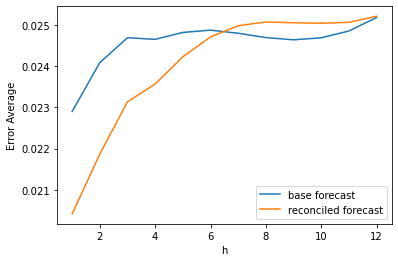

In [1068]:
import matplotlib.pyplot as plt

# Initialize lists to store the values for the two lines
base_forecast = []
reconciled_forecast = []

# Iterate over the range of h values from 1 to 12
for i in range(1, 13):
    # Calculate the values for the two lines using the error_average() function
    base_forecast.append(error_average(Dict_Errors, i, 'Low'))
    reconciled_forecast.append(error_average(Dict_recon_Errors, i, 'Low'))

# Plot the two lines using the plot() function from matplotlib
plt.plot(range(1, 13), base_forecast, label="base forecast")
plt.plot(range(1, 13), reconciled_forecast, label="reconciled forecast")

# Add labels for the x and y axes
plt.xlabel("h")
plt.ylabel("Error Average")

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()


# Hierarchical Model

In [99]:
avg1 = avg_1.set_index("date")
avg2 = avg_2.set_index("date")
avg3 = avg_3.set_index("date")
df_dis =  pd.concat([avg1 , avg2.pivot(columns='sa4', values='l01'), avg3.pivot(columns='postcode', values='l012')],axis = 1)

In [20]:
def transform_df(df_dis):
    # create a copy of df_dis to avoid modifying the original dataframe
    df_transformed = df_dis.copy()
     # subtract the value of each column in group 3 by the value of the corresponding column in group 2
    for col in avg_3_pivot.columns:
        sa4 = aveHPIdf_lv3.loc[aveHPIdf_lv3['postcode'] == col]['sa4'].iloc[0]
        df_transformed[col] = df_transformed[col].sub(df_transformed[sa4], axis=0)
    # subtract the value under column 'l0' from columns in group 2
    df_transformed[avg_2_pivot.columns] = df_transformed[avg_2_pivot.columns].sub(df_transformed['l0'], axis=0)
    return df_transformed

In [21]:
def reverse_transform_df(df_transformed):
    
    # create a copy of df_transformed to avoid modifying the original dataframe
    df_dis = df_transformed.copy()
    
    # add the value under column 'l0' back to columns in group 2
    df_dis[avg_2_pivot.columns] = df_dis[avg_2_pivot.columns].add(df_dis['l0'], axis=0)
    
    # add the value of each column in group 3 back to the value of the corresponding column in group 2
    for col in avg_3_pivot.columns:
        sa4 = aveHPIdf_lv3.loc[aveHPIdf_lv3['postcode'] == col]['sa4'].iloc[0]
        df_dis[col] = df_dis[col].add(df_dis[ sa4], axis=0)
    
    return df_dis


In [101]:
df_l = transform_df(df_dis)

In [106]:
with open("Dict_strt2Arimas.pickle", "wb") as file:
     pickle.dump(Dict_strt2Arimas, file)

In [116]:
df_len = 17

# Create an empty dictionary to store the columns
columns = {}

# Loop through the column names and create an empty list for each one
for col_name in hm_names:
    columns[col_name] = []

# Populate the columns with the desired length (17)
for i in range(df_len):
    for col_name in hm_names:
        columns[col_name].append(None)

# Create the dataframe from the dictionary of columns
new_df = pd.DataFrame(columns)


# Loop through each row index in new_df
for R in range(0,17):
    # Loop through each column name in new_df
    for key in new_df.columns:
        # Get the corresponding ARIMA model from Dict_strt2Arimas and predict one period
        arima_model = Dict_strt2Arimas[R + 120][key]['Model']
        prediction = arima_model.predict(n_periods=1, return_conf_int=False)[0]
        # Set the value in new_df to the predicted value
        new_df.loc[R, key] = prediction


In [104]:
def base_errors_2(colname, M):
    if colname == 'l0' or colname in avg_2_pivot.columns: 
    # Get the data for the specified column
        data = df_l[colname].values
        error_df = pd.DataFrame()

    # Initialize a matrix to store the forecasts
#     errors = np.zeros((N, data.shape[0] - M))

    # Loop over the rolling window
        for i in range(M, data.shape[0]):
            N = data.shape[0] - M
            training_data = data[i-M:i]
            test_data = data[i:i+N]

        # Fit ARIMA model to training data
            model = auto_arima(training_data, d = None, seasonal=False, suppress_warnings=True, error_action="ignore", stepwise=True, trace=False)
            arima = ARIMA(training_data, order=model.order)
            arima_fit = arima.fit()
    
        # Make N-step-ahead forecast 
            forecast = arima_fit.forecast(steps=N)
        # Check if the forecast is longer than the test_data
            if len(forecast) > len(test_data):
        # Calculate the difference between the lengths of the two arrays
                difference = len(forecast) - len(test_data)
    
        # Add the extra values from the forecast array to the end of the test_data array
                test_data = np.append(test_data, forecast[-difference:])
            error_df['sim'+str(i)] = forecast - test_data
        # Calculate average MSE for each series
        return  error_df
        
        

In [105]:
colnames = df_l.columns
M0  = 120
Dict_Errors_Hi = {}

for i, colname in enumerate(colnames):
    error_results = base_errors_2(colname,M0)
    Dict_Errors_Hi[colname] = error_results
    print(f'Progress: {i+1}/{len(colnames)}')


In [24]:
# with open("Dict_Errors_Hi.pickle", "wb") as file:
#     pickle.dump(Dict_Errors_Hi, file)

with open("Dict_Errors_Hi.pickle", "rb") as file:
     Dict_Errors_Hi = pickle.load(file)

In [25]:
# Create a list of keys to delete
keys_to_delete = []

# Iterate over the keys in Dict_Errors_Hi and identify any null dataframes
for key in Dict_Errors_Hi:
    if Dict_Errors_Hi[key] is None or Dict_Errors_Hi[key].empty:
        keys_to_delete.append(key)

# Delete the identified keys from Dict_Errors_Hi
for key in keys_to_delete:
    del Dict_Errors_Hi[key]

In [26]:
def forecast_base_2(M, h, Dict_Errors_Hi, df_l):
    forecasts = pd.DataFrame({}, columns=df_l.columns, index=df_l.index)

    # Loop over all dataframes in Dict_Errors
    for key in Dict_Errors_Hi:
        # Find the row in Dict_Errors with index h-1 and extract all values before the last h column
        errors = Dict_Errors_Hi[key].iloc[h-1, :Dict_Errors_Hi[key].shape[1]-h+1]

        # Calculate the length of the extracted values from Dict_Errors
        length = len(errors)

        # Cut df_yt[key] into two parts
        first_part = df_l[key].iloc[:-length]
        second_part = df_l[key].iloc[-length:]

        # Add the second part of df_yt[key] and the extracted values from Dict_Errors to the forecast dataframe
        forecasts.loc[second_part.index, key] = second_part.values + errors.values


    return forecasts


In [30]:
M0=120
ARIMAforecasts = forecast_base_2(M0, 1, Dict_Errors_Hi, df_l)
ARIMAforecasts = ARIMAforecasts.reset_index(drop = True)

In [31]:
from sklearn.linear_model import LinearRegression
def ini_onestepforecast_hi(colname, M):
    if colname in avg_3_pivot.columns: 
    # Get the data for the specified column
        sa4 = aveHPIdf_lv3.loc[aveHPIdf_lv3['postcode'] == colname]['sa4'].iloc[0]
        results_array = np.empty((df_l.shape[0]-M,)) 
        for i in range(M, df_l.shape[0]):
            N = data.shape[0] - M
            train_start = i - M
            train_end = i - 1
            test_start = i
            test_end = i + N
            train_X = df_l[['l0', sa4]][train_start:train_end+1].values
            train_Y = df_l[colname][train_start:train_end+1].values
            model = LinearRegression().fit(train_X, train_Y)           
            test_X =np.array(ARIMAforecasts.iloc[test_start][['l0', sa4]]).reshape(1,-1)
            test_Y_pred = model.predict(test_X)
            results_array[i-M] = test_Y_pred 
        # Calculate average MSE for each series
        return  results_array
        

In [32]:
df_onestep = ARIMAforecasts.copy().dropna(how='all').reset_index(drop = True)
# Print the resulting DataFrame

In [33]:
for col in avg_3_pivot.columns:
    
    # Generate one-step forecasts using ini_onestepforecast_hi
    forecasts = ini_onestepforecast_hi(col, M0)
    
    # Add the forecasts to the ARIMAforecasts dataframe
    df_onestep[col] = forecasts

In [34]:
df_onestep

,l0,Capital Region,Central Coast,Central West,Coffs Harbour - Grafton,Far West and Orana,Hunter Valley exc Newcastle,Illawarra,Mid North Coast,Murray,...,2760,2763,2770,2774,2782,2795,2800,2829,2830,2871
0,0.018238,-0.011204,-0.004856,-0.009592,-0.004333,-0.033101,-0.010765,-0.003221,-0.00496,-0.010723,...,0.001310,0.000398,-0.000398,-0.003165,-0.005123,0.000534,-0.002867,0.000765,0.012183,0.002332
1,0.013868,-0.007653,-0.00521,0.002512,-0.003672,-0.01691,-0.010988,-0.002102,-0.003652,-0.0119,...,-0.000563,0.000151,-0.000151,-0.001769,-0.003846,-0.004101,-0.004238,0.002461,0.003886,0.008340
2,0.017186,-0.013381,-0.002929,-0.000656,0.002967,-0.001577,-0.009151,-0.001857,-0.003598,-0.005672,...,0.001136,-0.000053,0.000053,-0.003158,-0.005275,-0.003806,-0.004006,0.005762,-0.008144,0.007812
3,0.008829,-0.007429,-0.000915,-0.007211,0.002153,0.003554,-0.007146,-0.000451,-0.009982,-0.007409,...,0.001874,-0.001362,0.001362,-0.001600,-0.002300,0.001512,-0.001174,0.003872,-0.006530,-0.000339
4,0.00442,-0.007048,0.000536,-0.002125,-0.000112,-0.003564,-0.004851,0.000749,0.001658,-0.005407,...,0.003942,-0.001348,0.001348,-0.001305,-0.000494,0.000233,-0.001217,-0.000148,0.001265,0.000984
5,-0.005089,0.000611,-0.000896,-0.000021,-0.008307,-0.000912,-0.004994,0.00186,-0.001819,-0.001284,...,0.001177,-0.001654,0.001654,0.001722,0.002563,0.001501,0.000688,-0.002064,0.005321,-0.002190
6,-0.00319,0.005282,0.000415,0.004207,0.005526,0.009382,-0.003466,0.004988,-0.004375,-0.001467,...,0.000161,-0.000818,0.000818,0.001720,0.001375,-0.000933,-0.000552,0.000418,-0.002376,0.001484
7,-0.004459,0.003672,0.002621,0.016155,-0.000133,0.030885,-0.000563,0.004609,0.001489,0.000046,...,-0.000432,-0.000822,0.000822,0.002327,0.002104,-0.005722,-0.003631,0.004548,-0.015647,0.009353
8,-0.002355,0.006772,0.004402,0.014616,0.005754,0.008673,0.002854,0.003617,0.001858,0.002251,...,-0.000923,-0.001533,0.001533,0.002074,0.001379,-0.005188,-0.003352,0.000018,-0.002286,0.008540
9,0.002889,0.003538,0.004494,0.006539,-0.001266,0.005127,0.006574,0.000856,0.008493,-0.000556,...,-0.000389,-0.000765,0.000765,0.000713,-0.000268,-0.003124,-0.002604,0.000654,-0.003219,0.005727


In [35]:
df_onestep_ori = reverse_transform_df(df_onestep)
df_onestep_ori = df_onestep_ori.filter(avg_3_pivot.columns, axis=1)
df_true = df_dis.copy().reset_index(drop = True)
df_true = df_true.tail(df_onestep_ori.shape[0]).reset_index(drop = True)
error_copula = (df_onestep_ori - df_true).dropna(axis = 1) 

In [36]:
import copulae
from copulae import EmpiricalCopula, pseudo_obs
from copulae.datasets import load_marginal_data
df  = error_copula

df_emp = df
u = pseudo_obs(df)
emp_cop = EmpiricalCopula(u, smoothing="none")
df_vol = EmpiricalCopula.to_marginals(emp_cop.random(2000, seed=10), df)

In [38]:
S_u =S[:S.shape[0]- S.shape[1],:]
S_u = S_u / np.sum(S_u, axis=1, keepdims=True)

In [39]:
def str2key(colname,ARIMAModel_Dict):
    key_to_find = colname

# Convert the keys of the dictionary to a list
    keys_list = list(ARIMAModel_Dict.keys())

# Use the index() method of the list to get the position of the key
    if key_to_find in keys_list:
        key_position = keys_list.index(key_to_find)
        return key_position    
    else:
        print("Key {} is not present in the dictionary".format(key_to_find))
        

In [40]:
df_ll = df_l.copy().reset_index(drop = True)
# Combine the dataframes
combined_df = pd.concat([avg1, avg_2_pivot], axis=1)
hm_names = list(combined_df.columns)

In [41]:
def ARIMA_generator(M,i,colname):
    data = df_l[colname].values
    training_data_ARMA = data[i-M:i]
    arima_model = auto_arima(training_data_ARMA , seasonal=False, suppress_warnings=True)
    return arima_model,training_data_ARMA 

In [42]:
def strtpoint2ARIMAModel_Dict_init(M,i):
    ARIMAModel_Dict = {}
    for col in hm_names:
        model,training_data = ARIMA_generator(M,i,col)
        ARIMAModel_Dict[col] = {'Model':model, 'Data':  training_data }   
    return ARIMAModel_Dict

In [43]:
def ARIMA_modifier(arr_newdata):
    arr = []
    for i in range(0,len(arr_newdata)):
        key = list(df_l.columns)[i]
        ARIMAModel_Dict[key]['Model'] = ARIMAModel_Dict[key]['Model'].update(arr_newdata[i])
        l_new =ARIMAModel_Dict[key]['Model'].predict(n_periods=1, return_conf_int=False)[0]
        arr.append(l_new)
    return  arr  

In [1615]:
# i = 120
# M0  = 120
# ARIMAModel_Dict0 = strtpoint2ARIMAModel_Dict_init(M0,i)

# arr_of_arrs_of_arrs = []
# for sim in range (0,Sim_Times):
    
#     ARIMAModel_Dict = ARIMAModel_Dict0.copy()
    
#     arr_of_arrs = []
#     for steps in range (0, df_l.shape[0] - i):
#         l_before_aj = []
#         random_int = random.randint(0, 1999)
#         for key in ARIMAModel_Dict.keys():
#             model = ARIMAModel_Dict[key]['Model']
#             l_before_aj.append(model.predict(n_periods=1, return_conf_int=False)[0])
            
#         arr = []
#         for postcode in list(avg_3_pivot.columns):
#             sa4 = aveHPIdf_lv3.loc[aveHPIdf_lv3['postcode'] == postcode]['sa4'].iloc[0]
#             N = df_ll.shape[0] - M
#             train_start = i - M
#             train_end = i - 1
#             test_start = i
#             train_X = df_ll.loc[train_start:train_end+1,['l0', sa4]].values
#             train_Y = df_ll.loc[train_start:train_end+1,postcode]
#             model = LinearRegression().fit(train_X, train_Y)           
#             test_X = np.array([l_before_aj[0],l_before_aj[str2key(sa4)]]).reshape(1,-1)
#             test_Y_pred = model.predict(test_X) 
#             l012_next = test_Y_pred + np.sum(test_X) + df_vol[postcode].iloc[random_int]
#             arr.append(l012_next[0])
            
          
#         arr_newdata = np.dot(S_u, arr)
#         first_element = arr_newdata[0]
#         for k in range(1, len(arr_newdata)):
#             arr_newdata[k] = arr_newdata[k] - first_element  
#         l_before_aj = ARIMA_modifier(arr_newdata)
#         arr_of_arrs.append(arr)  
        
#     arr_of_arrs_of_arrs.append(arr_of_arrs)   
# d3_arr = np.array(arr_of_arrs_of_arrs)
# avg_arr = np.mean(d3_arr, axis=0)


In [45]:
def Forecasts_sim(M, i, ARIMAModel_Dict0):
    ARIMAModel_Dict = ARIMAModel_Dict0.copy()
    arr_of_arrs = []
    for steps in range (0, df_l.shape[0] - i):
        l_before_aj = []
        
        for key in ARIMAModel_Dict.keys():
            model = ARIMAModel_Dict[key]['Model']
            l_before_aj.append(model.predict(n_periods=1, return_conf_int=False)[0])
            
        arr = []
        random_int_vol = random.randint(0, 1999)
        for postcode in list(avg_3_pivot.columns):
            sa4 = aveHPIdf_lv3.loc[aveHPIdf_lv3['postcode'] == postcode]['sa4'].iloc[0]
            N = df_ll.shape[0] - M
            train_start = i - M
            train_end = i - 1
            test_start = i
            train_X = df_ll.loc[train_start:train_end+1,['l0', sa4]].values
            train_Y = df_ll.loc[train_start:train_end+1,postcode]
            model = LinearRegression().fit(train_X, train_Y)           
            test_X = np.array([l_before_aj[0],l_before_aj[str2key(sa4, ARIMAModel_Dict)]]).reshape(1,-1)
            test_Y_pred = model.predict(test_X) 
            l012_next = test_Y_pred + np.sum(test_X) + df_vol[postcode].iloc[random_int_vol]
            arr.append(l012_next[0])
        
        arr_newdata = np.dot(S_u, arr)
        first_element = arr_newdata[0]
        for k in range(1, len(arr_newdata)):
            arr_newdata[k] = arr_newdata[k] - first_element  
    
        l_before_aj = []
        for i in range(0,len(arr_newdata)):
            key = list(df_l.columns)[i]
            ARIMAModel_Dict[key]['Model'] = ARIMAModel_Dict[key]['Model'].update(arr_newdata[i])
            l_new =ARIMAModel_Dict[key]['Model'].predict(n_periods=1, return_conf_int=False)[0]
            l_before_aj.append(l_new)
    


        arr_of_arrs.append(arr)  
    return arr_of_arrs



In [46]:
with open("Dict_strt2Arimas.pickle", "rb") as file:
    Dict_strt2Arimas = pickle.load(file)

In [47]:
# Dict_strt2Arimas = {}

# for i in range(M0, df_l.shape[0]):
#     Dict_strt2Arimas[i] = strtpoint2ARIMAModel_Dict_init(M0, i)




In [48]:
# with open("Dict_strt2Arimas.pickle", "wb") as file:
#     pickle.dump(Dict_strt2Arimas, file)



In [50]:
def calculate_sim_forecast(i):
    ARIMAModel_Dict0 = Dict_strt2Arimas[i]  
    arr_of_arrs_of_arrs = []
    for sim in range (0,Sim_Times):
        arr_of_arrs = Forecasts_sim(M0, i, ARIMAModel_Dict0 )
        arr_of_arrs_of_arrs.append(arr_of_arrs)
    d3_arr = np.array(arr_of_arrs_of_arrs)
    avg_arr = np.mean(d3_arr, axis=0)
    arrays = [avg_arr[:, j] for j in range(avg_3_pivot.shape[1])]
    desired_length = df_l.shape[0] - M0
    k = 0
    for key in Forecasts_dict.keys():
        # Get the current length of the array (assuming it's a 1D NumPy array)
        my_array = arrays[k]
        current_length = len(my_array )
        # If the current length is smaller than the desired length, pad with zeros
        if current_length < desired_length:
            zeros_to_add = desired_length - current_length
            my_array = np.pad(my_array, (0, zeros_to_add), mode='constant', constant_values=0)
        
        Forecasts_dict[key]['window'+str(i - M0 + 1)] = my_array
        k = k +1 

In [49]:
Forecasts_dict = {}
num_cols = df_l.shape[0] - M0
# Iterate over the columns in avg_3_pivot
for colname in avg_3_pivot.columns:
    new_df = pd.DataFrame({}, columns=['window'+str(k) for k in range(1, num_cols+1)])
    Forecasts_dict[colname] = new_df


In [73]:
Sim_Times = 2
random.seed(42)
Sim_Times =10
for i in range(M0, df_l.shape[0]):
    calculate_sim_forecast(i)
    print(i) 

        
    

120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136


In [88]:
Hier_Errors_dict = {}
for key in Forecasts_dict.keys():
    test_df = pd.DataFrame({})
    data = df_dis[key].values
    # Add a column for each window
    for w in range(1, 18):
        p = 18 - w
        last_p = data[-p:]
        new_array = np.zeros(17 - p)
        new_array = np.concatenate((last_p, new_array))
        test_df[f"window{w}"] = new_array
    # Add the new dataframe to Hier_Errors_dict with the same key as in Forecasts_dict
#     errors_df = Forecasts_dict[key].iloc[t]  -  test_df
    errors_df =  -  test_df
    Hier_Errors_dict[key] = errors_df

In [89]:
def error_average_hier(Dict_Name, h, M):
    col_names = avg_3_pivot.columns
    dfs = []
    for col in col_names:
        try:
            df = Dict_Name[col]
            dfs.append(df)
        except KeyError:
            print(f"Warning: Could not find dataframe for key {col}.")


    # calculate RMSE for each dataframe and find average by row
    rmse_by_row = []
    for df in dfs:
        df_error = df.iloc[0: h+1, 0:len(df_l)-M-h].copy()
        # calculate RMSE by row
        rmse_by_row.append(np.sqrt(np.mean((df_error.values)**2)))

    # calculate average of average RMSE by row
    if rmse_by_row:
        average_rmse = np.mean([np.mean(rmse) for rmse in rmse_by_row])
    else:
        average_rmse = np.nan

    return average_rmse

In [97]:
error_average_hier(Hier_Errors_dict, 1, M0)



0.02810783096932349